In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools

%matplotlib inline

In [2]:
class PID(object):
    def __init__(self, dState=0, iState=0, iMin=0, iMax=100, Kp=1, Ki=0, Kd=0):
        self.dState = dState  # Last position input
        self.iState = iState  # Integrator state
        self.iMin   = iMin    # minimum allowable integrator state
        self.iMax   = iMax    # maximum allowable integrator state
        self.Kp     = Kp      # proportional gain
        self.Ki     = Ki      # integral gain
        self.Kd     = Kd      # derivative gain

In [3]:
def updatePID(pid, error, position):
    
    #proportional term
    p = pid.Kp * error
    
    # calculate the integral state with appropriate limiting
    pid.iState += error
    if pid.iState > pid.iMax:
        pid.iState = pid.iMax
    elif pid.iState < pid.iMin:
        pid.iState = pid.iMin
    
    i = pid.Ki * pid.iState
    
    #derivative term
    d = pid.Kd * (pid.dState - position)
    pid.dState = position
    
    return p + i + d    

In [4]:
def newtonsLawOfCooling(T_0, T_a=15.1, k=0.001859):
    t = itertools.count(0)
    return lambda x: x + (T_0 - T_a)*(math.exp(-k) - 1)*math.exp(-k*next(t))

In [5]:
def humidityfunct(k):
    return lambda x: x + k

In [6]:
def CO2funct(k):
    return lambda x: x + k

In [7]:
def plantsys(u_t, measured, plant_process):
    return plant_process(measured + u_t)

In [27]:
def simulate(initial, desired, PIDs, functs):
    n = len(PIDs)
    measurements = [initial]
    measured     = initial
    
    for i in range(100):
        error    = desired - measured
        u_t      = [updatePID(pid, err, measure) for pid, err, measure in zip(PIDs, error, measured)]
        measured = [plantsys(u, measure, funct)  for u, measure, funct in zip(u_t, measured, functs)]
        measurements.append(measured)
    return np.array(measurements)

In [ ]:
def zieglerNichols(initial, desired, funct):
    pid = PID()
    K_c = 1.0
    T_i = 0.0
    T_d = 0.0
    
    OK = False
    i = 0
    
    res = []
    
    while(not OK):
        measurements = simulate([initial], [desired], [pid], [funct])[0]
        error = measurements - desired
        res.append(sum(error**2), K_c)
        
        K_c += 0.001
        
        i += 1
        if(i == 10000):
            OK = True

### Setup

In [24]:
tempPID = PID(Kp=0.2, Ki=0.1, Kd=0.05)
humiPID = PID(Kp=0.2, Ki=0.1, Kd=0.05)
CO2PID  = PID(Kp=0.2, Ki=0.1, Kd=0.05)
PID3    = [tempPID, humiPID, CO2PID]

temperature, humidity, CO2 = range(3)
plant_process = [newtonsLawOfCooling(T_0=25), humidityfunct(k=3.0), CO2funct(2.0)]

desired  = np.zeros(3)
measured = np.zeros(3)

desired[temperature]  = 23.9
desired[humidity]     = 50
desired[CO2]          = 555

measured[temperature] = 20
measured[humidity]    = 33
measured[CO2]         = 700

### Simulate

In [25]:
measurements = simulate(measured, desired, PID3, plant_process)

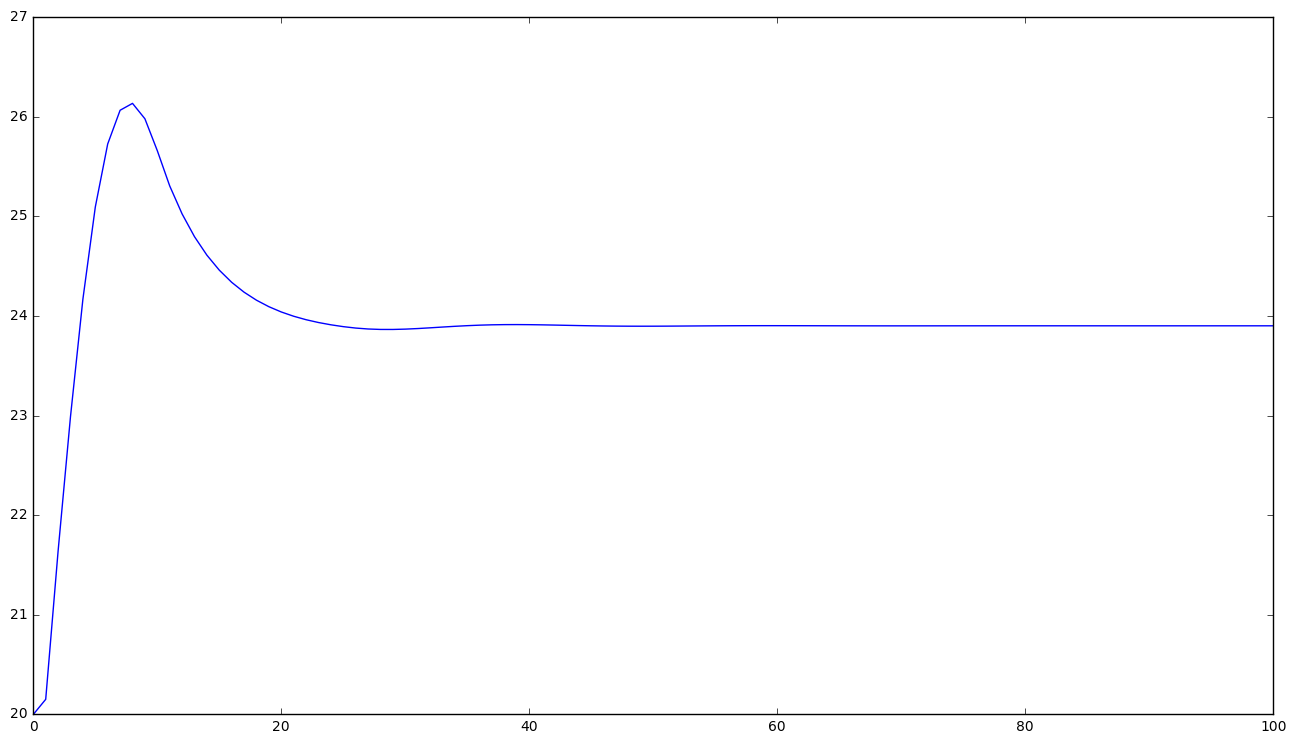

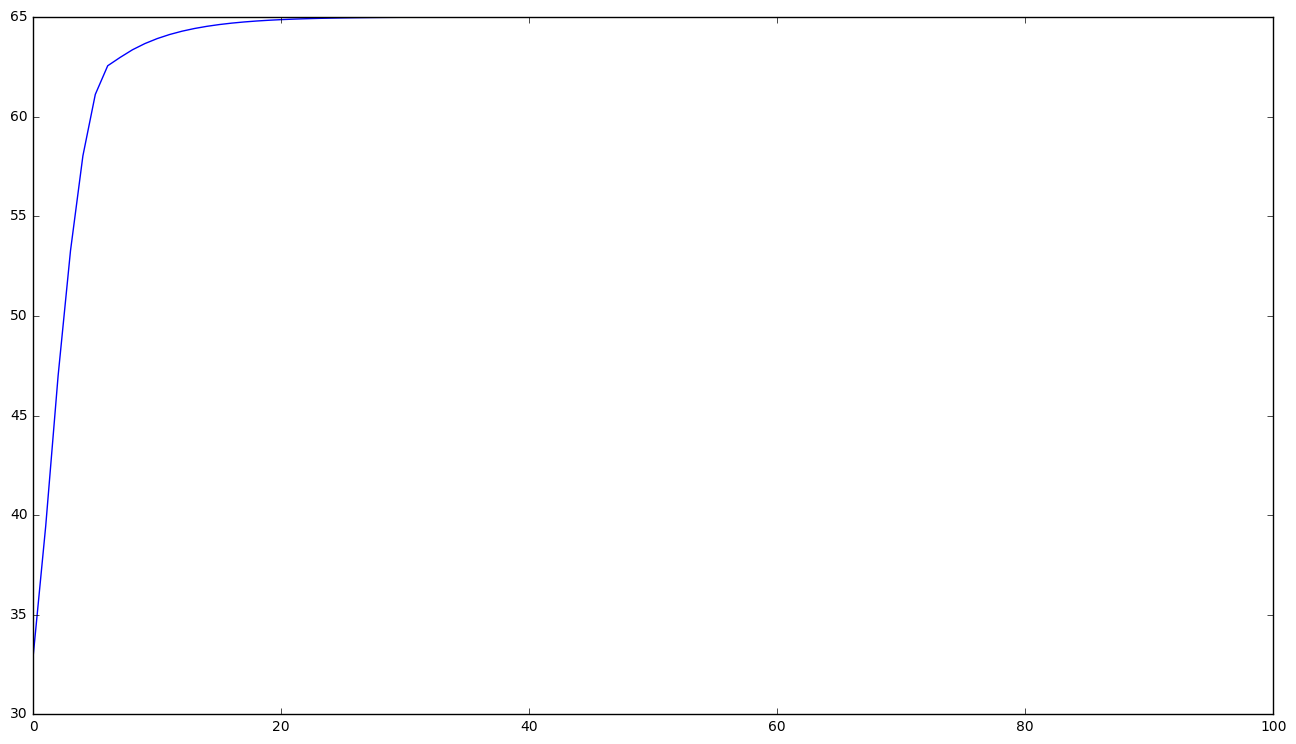

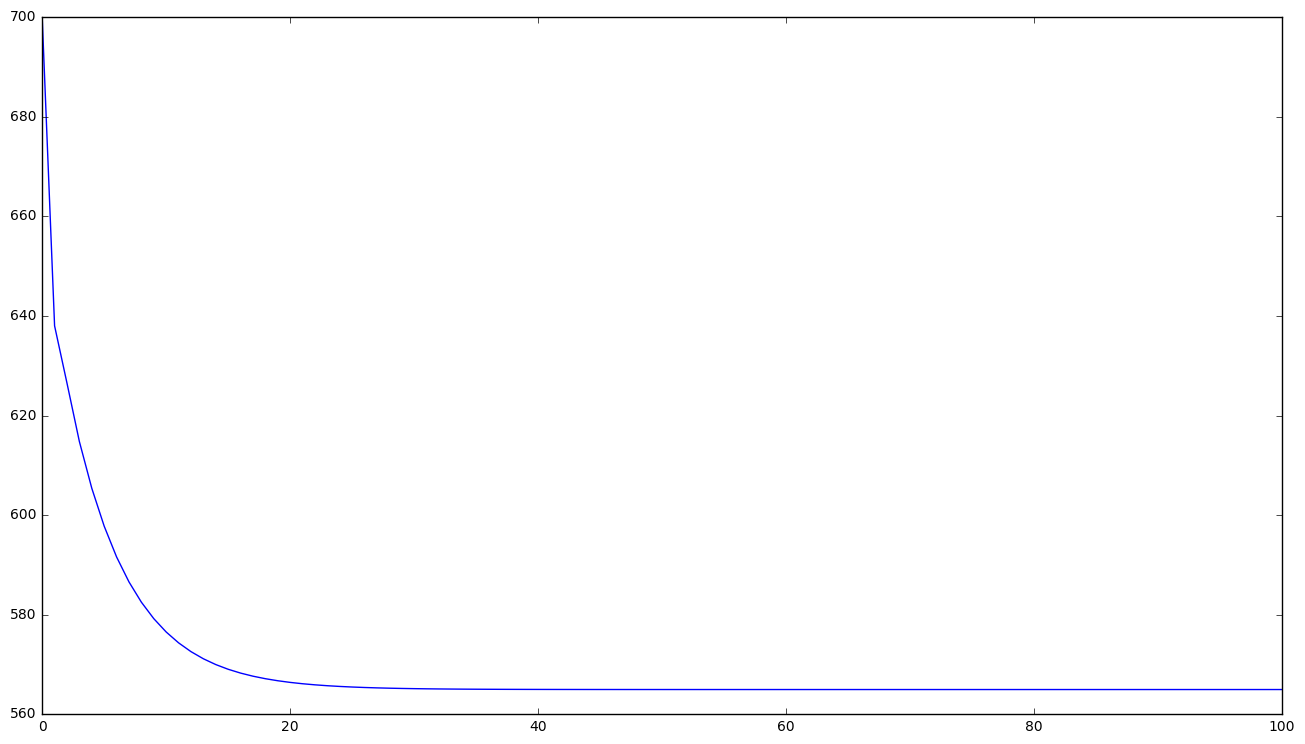

In [26]:
for M in measurements.T:
    plt.figure(figsize=(16,9))
    plt.plot(range(101),M)